In [8]:
#| default_exp cameras

# OpenHSI Hardware Camera Implementations

:::{.callout-tip}

This module can be imported using `from openhsi.cameras import *`

:::

Wrapper class and example code for getting images from the OpenHSI.

:::{.callout-tip}

To use the camera, you will need some calibration files. You can also generate these files following this [guide](https://openhsi.github.io/openhsi/tutorial_calibrate.html) which uses the [`calibrate` module](https://openhsi.github.io/openhsi/calibrate.html).

:::

In [9]:
#| hide
import sys
sys.path.append('/home/ubuntu/Documents/openhsi/')


# documentation extraction for class methods
from nbdev.showdoc import *

# unit tests using test_eq(...)
from fastcore.test import *

# monkey patching class methods using @patch
from fastcore.foundation import *
from fastcore.foundation import patch

# imitation of Julia's multiple dispatch using @typedispatch
from fastcore.dispatch import typedispatch

# bring forth **kwargs from an inherited class for documentation
from fastcore.meta import delegates

# external
import numpy as np
import ctypes
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
from functools import partial

# internal
from openhsi.capture import OpenHSI
from openhsi.shared import SharedOpenHSI

## IDS

Follow the install instructions for [https://pypi.org/project/simple-pyspin/](IDS peak). This includes the Spinnaker SDK and the Python pyspin .whl file from [https://flir.app.boxcn.net/v/SpinnakerSDK](https://flir.app.boxcn.net/v/SpinnakerSDK). 

:::{.callout-note}

ids_peak 2.8 only supports Python 3.7-3.11

:::

There are some additional settings:
- `win_resolution`: size of area on detector to readout (width, height)
- `win_offset`: offsets (x,y) from edge of detector for a selective 
- `exposure_us`: is the camera exposure time to use in microseconds

In [12]:
#| export cameras
"""
@file    reconnect_callbacks.py
@author  IDS Imaging Development Systems GmbH
@date    2023-11-08

@brief   This application demonstrates how to register device connection change callbacks and handle a reconnected device

@version 1.0.1

Copyright (C) 2023 - 2024, IDS Imaging Development Systems GmbH.

The information in this document is subject to change without notice
and should not be construed as a commitment by IDS Imaging Development Systems GmbH.
IDS Imaging Development Systems GmbH does not assume any responsibility for any errors
that may appear in this document.

This document, or source code, is provided solely as an example of how to utilize
IDS Imaging Development Systems GmbH software libraries in a sample application.
IDS Imaging Development Systems GmbH does not assume any responsibility
for the use or reliability of any portion of this document.

General permission to copy or modify is hereby granted.
"""
from ids_peak import ids_peak
from ids_peak_ipl import ids_peak_ipl
from ids_peak import ids_peak_ipl_extension

from typing import Optional


class IDSCam:
    def __init__(self):
        # Initialize library, has to be matched by a Library.Close() call
        ids_peak.Library.Initialize()

        self.device_manager: ids_peak.DeviceManager = ids_peak.DeviceManager.Instance()
        self.acquisition_running: bool = False
        self.device: Optional[ids_peak.Device] = None
        self.remote_nodemap: Optional[ids_peak.NodeMap] = None
        self.data_stream: Optional[ids_peak.DataStream] = None

        self.register_callbacks()

    @staticmethod
    def device_found(device: ids_peak.DeviceDescriptor):
        """
        The 'found' event is triggered if a new device is found upon calling
        `DeviceManager.Update()`
        """
        print(f"Found-Device-Callback: Key={device.Key()}")

    @staticmethod
    def device_lost(key: str):
        """
        The 'lost' event is only called for this application's opened devices if
        a device is closed explicitly or if connection is lost while the reconnect is disabled,
        otherwise the 'disconnected' event is triggered.
        Other devices that were not opened or were opened by someone else still trigger
        a 'lost' event.
        """
        print(f"Lost-Device-Callback: Key={key}")

    def ensure_compatible_buffers_and_restart_acquisition(
            self,
            reconnect_information: ids_peak.DeviceReconnectInformation
    ):
        """
        After a reconnect the PayloadSize might have changed, e.g. due to
        a reboot and the last parameter state not being saved in the
        starting UserSet. Here we check the PayloadSize and
        reallocate the buffers if we encounter a mismatch.

        We also start the local and remote acquistion if necessary.
        """
        payload_size = self.remote_nodemap.FindNode("PayloadSize").Value()

        has_payload_size_mismatch = payload_size != self.data_stream.AnnouncedBuffers()[
            0].Size()

        # The payload size might have changed. In this case it's required to reallocate the buffers.
        if has_payload_size_mismatch:
            print("PayloadSize has changed. Reallocating buffers...")

            is_data_stream_running = self.data_stream.IsGrabbing()
            if is_data_stream_running:
                self.data_stream.StopAcquisition()

            self.revoke_buffers()

            # Allocate and queue the buffers using the new "PayloadSize".
            self.alloc_buffers()

            if is_data_stream_running:
                self.data_stream.StartAcquisition()

        if not reconnect_information.IsRemoteDeviceAcquisitionRunning():
            self.remote_nodemap.FindNode("AcquisitionStart").Execute()

    def device_reconnected(self, device: ids_peak.Device,
                           reconnect_information: ids_peak.DeviceReconnectInformation):
        """
        When a device that was opened by the same application instance regains connection
        after a previous disconnect the 'Reconnected' event is triggered.

        The reconnect may (partially) fail, so we have to check the `DeviceReconnectInformation`
        class to know what steps are necessary to resume the acquistion.
        """
        print((
            "Device-Reconnected-Callback:/n"
            f"Key={device.Key()}\n"
            f"ReconnectSuccessful: {reconnect_information.IsSuccessful()}/n"
            f"RemoteDeviceAcquisitionRunning: {reconnect_information.IsRemoteDeviceAcquisitionRunning()}/n"
            f"RemoteDeviceConfigurationRestored: {reconnect_information.IsRemoteDeviceConfigurationRestored()}"
        ))

        # Using the `reconnectInformation` the user can tell whether they need to take actions
        # in order to resume the image acquisition.
        if reconnect_information.IsSuccessful():
            # Device was reconnected successfully, nothing to do.
            return

        self.ensure_compatible_buffers_and_restart_acquisition(
            reconnect_information)

    @staticmethod
    def device_disconnected(device: ids_peak.DeviceDescriptor):
        """
        Only called if the reconnect is enabled and if the device was previously opened by this
        application instance.
        """
        print(f"Disconnected-Callback: Key={device.Key()}")

    def register_callbacks(self):
        """
        Register the Devicemanager callbacks.

        Note: We have to store the callbacks, otherwise the callbacks will be unregistered because their
        lifetime is shorter than the device manager instance.
        """
        # ids_peak provides several events that you can subscribe to in order
        # to be notified when the connection status of a device changes.
        self.device_found_callback = self.device_manager.DeviceFoundCallback(
            self.device_found)
        self.device_found_callback_handle = self.device_manager.RegisterDeviceFoundCallback(
            self.device_found_callback)

        self.device_lost_callback = self.device_manager.DeviceLostCallback(
            self.device_lost)
        self.device_lost_callback_handle = self.device_manager.RegisterDeviceLostCallback(
            self.device_lost_callback)

        self.device_reconnected_callback = self.device_manager.DeviceReconnectedCallback(
            self.device_reconnected)
        self.device_reconnected_callback_handle = self.device_manager.RegisterDeviceReconnectedCallback(
            self.device_reconnected_callback)

        self.device_disconnected_callback = self.device_manager.DeviceDisconnectedCallback(
            self.device_disconnected)
        self.device_disconnected_callback_handle = self.device_manager.RegisterDeviceDisconnectedCallback(
            self.device_disconnected_callback)

    def unregister_callbacks(self):
        """
        Unregister the registered callbacks inside the Devicemanager
        """
        self.device_manager.UnregisterDeviceFoundCallback(
            self.device_found_callback_handle)
        self.device_manager.UnregisterDeviceLostCallback(
            self.device_lost_callback_handle)
        self.device_manager.UnregisterDeviceReconnectedCallback(
            self.device_reconnected_callback_handle)
        self.device_manager.UnregisterDeviceDisconnectedCallback(
            self.device_disconnected_callback_handle)

    def run_acquisition_loop(self):
        """
        Run the acquisition loop. The reconnect callback may abort this.
        """

        # Lock writeable nodes during acquisition
        self.remote_nodemap.FindNode("TLParamsLocked").SetValue(1)

        self.data_stream.StartAcquisition()
        self.remote_nodemap.FindNode("AcquisitionStart").Execute()
        self.remote_nodemap.FindNode("AcquisitionStart").WaitUntilDone()

        self.acquisition_running = True
        print("Starting acquisition...")
        print("Now you can disconnect or reboot the device to trigger a reconnect!")
        while self.acquisition_running:
            try:
                # Wait for finished/filled buffer event
                buffer = self.data_stream.WaitForFinishedBuffer(
                    ids_peak.Timeout.INFINITE_TIMEOUT)
                print(f"Received FrameID: {buffer.FrameID()}")
                # Put the buffer back in the pool, so it can be filled again
                self.data_stream.QueueBuffer(buffer)
            except KeyboardInterrupt:
                print("Keyboard interrupt.")
                break
            except Exception as e:
                print(f"Exception: {e}")

        print("Stopping acquisition...")
        self.remote_nodemap.FindNode("AcquisitionStop").Execute()
        self.remote_nodemap.FindNode("AcquisitionStop").WaitUntilDone()
        self.data_stream.StopAcquisition(
            ids_peak.AcquisitionStopMode_Default)

        # Unlock writeable nodes again
        self.remote_nodemap.FindNode("TLParamsLocked").SetValue(0)
    



    def get_image(self):
        # Tries to access a image
        try:
            # Get buffer from device's DataStream. Wait 5000 ms. The buffer is automatically locked until it is queued again.
            
            buffer = self.data_stream.WaitForFinishedBuffer(5000)
        
            
            
            """image = ids_peak_ipl.BufferToImage(buffer)
"""
            image = ids_peak_ipl.Image.CreateFromSizeAndBuffer(
                buffer.PixelFormat(),
                buffer.BasePtr(),
                buffer.Size(),
                buffer.Width(),
                buffer.Height()
            )
            
            #print(buffer.PixelFormat())
            # print(buffer.Width())
            # print(buffer.Height())

            #image_processed = image.ConvertTo(ids_peak_ipl.PixelFormatName_Mono12, ids_peak_ipl.ConversionMode_Classic)
            #print(ids_peak_ipl.Image.get_numpy())
            # Queue buffer again
            self.data_stream.QueueBuffer(buffer)
            
            
            
            return np.transpose(image.get_numpy())
        except Exception as e:
            # ...
            str_error = str(e)
            print(str_error)



    def open_device(self):
        # Open the first device
        device = None
        for dev in self.device_manager.Devices():
            if dev.IsOpenable(ids_peak.DeviceAccessType_Control):
                device = dev.OpenDevice(ids_peak.DeviceAccessType_Control)

        # Exit program if no device was found
        if not device:
            raise Exception("No device found. Exiting Program.")

        self.device = device

        print("Using Device " + self.device.DisplayName())
        self.remote_nodemap = self.device.RemoteDevice().NodeMaps()[0]
        self.data_stream = self.device.DataStreams()[0].OpenDataStream()

    def enable_reconnect(self):
        """
        We enable the reconnect by writing to the `ReconnectEnable` node
        in the `NodeMap` of the `System` that our device is connected to.
        """

        system_node_map = self.device.ParentInterface().ParentSystem().NodeMaps()[0]

        if not system_node_map.HasNode("ReconnectEnable"):
            raise SystemExit("No ReconnectEnable Node found!")

        reconnect_enable_node = system_node_map.FindNode("ReconnectEnable")
        reconnect_enable_access_status = reconnect_enable_node.AccessStatus()

        if reconnect_enable_access_status == ids_peak.NodeAccessStatus_ReadWrite:
            reconnect_enable_node.SetValue(True)
            return

        if reconnect_enable_access_status == ids_peak.NodeAccessStatus_ReadOnly:
            if reconnect_enable_node.Value():
                return

        raise SystemExit("Error: ReconnectEnable cannot be set to true!")

    def load_defaults(self):
        self.remote_nodemap.FindNode(
            "UserSetSelector").SetCurrentEntry("Default")
        # Same as UserSetSelector = Default; in cpp
        self.remote_nodemap.FindNode("UserSetLoad").Execute()
        # Same as UserSetLoad(); in cpp
        self.remote_nodemap.FindNode("UserSetLoad").WaitUntilDone()
        # Same as UserSetLoad(); in cpp
        # ...

        

        #
        

    def alloc_buffers(self):
        # Buffer size
        payload_size = self.remote_nodemap.FindNode("PayloadSize").Value()

        # Minimum number of required buffers
        buffer_count_max = self.data_stream.NumBuffersAnnouncedMinRequired()

        # Allocate buffers and add them to the pool
        for buffer_count in range(buffer_count_max):
            # Let the TL allocate the buffers
            buffer = self.data_stream.AllocAndAnnounceBuffer(payload_size)
            # Put the buffer in the pool
            self.data_stream.QueueBuffer(buffer)

    def revoke_buffers(self):
        # Remove buffers from any associated queue
        self.data_stream.Flush(ids_peak.DataStreamFlushMode_DiscardAll)

        for buffer in self.data_stream.AnnouncedBuffers():
            # Remove buffer from the transport layer
            self.data_stream.RevokeBuffer(buffer)

    def set_roi(self):
        # In order to restart the acquistion additonal steps are required:
        # see "The payload size might have changed." above
        self.remote_nodemap.FindNode("Height").SetValue(512)
        self.remote_nodemap.FindNode("Width").SetValue(512)

    def run(self):
        try:
            # Update the DeviceManager
            ids_peak.DeviceManager.Instance().Update()

            # Open first available device
            self.open_device()

            # Enable reconnect
            self.enable_reconnect()

            # Load default camera settings. This could be replaced with loading from sonfig files
            self.load_defaults()

            exposure_time = 50 # Ms

            self.remote_nodemap.FindNode("ExposureTime").SetValue(exposure_time)

            # NOTE: Uncommenting this line will modify the PayloadSize without saving the
            # changes in the UserSet. If the device reboots (e.g. by losing and then regaining
            # power) the PayloadSize will have changed, which means the acquisition on
            # the remote device will not be restarted.
            # self.set_roi()

            # Allocate buffers for the acquisition
            self.alloc_buffers()

            # Run acquisition loop until an error occurs or the user presses Ctrl+C
            self.run_acquisition_loop()

            # Revoke all buffers
            self.revoke_buffers()

        except ids_peak.AbortedException:
            print("Aborted")
        except Exception as e:
            print("EXCEPTION: " + str(e))
            return -2

        finally:
            self.unregister_callbacks()
            ids_peak.Library.Close()


"""if __name__ == '__main__':
    example = IDSCam()
    example.run()"""


"if __name__ == '__main__':\n    example = IDSCam()\n    example.run()"

In [13]:
#| export cameras

@delegates()
class IDSCameraBase(OpenHSI):
    """Interface for IDS camera"""
    
    def __init__(self, **kwargs):
        """Initialise IDS camera
        
        Any keyword-value pair arguments must match the those avaliable in settings file. IDSCamera expects the ones listed below:

        - `binxy`: number of pixels to bin in (x,y) direction
        - `win_resolution`: size of area on detector to readout (width, height)
        - `win_offset`: offsets (x,y) from edge of detector for a selective 
        - `exposure_ms`: is the camera exposure time to use
        - `pixel_format`: format of pixels readout sensor, ie Mono8, Mono10, Mono12
    """
        print("IDSCameraBase __init__")
        print(kwargs)
        super().__init__(**kwargs)
        
        self.idscam = IDSCam()

        # Update the DeviceManager
        ids_peak.DeviceManager.Instance().Update()

        # Open first available device
        self.idscam.open_device()

        # Enable reconnect
        self.idscam.enable_reconnect()

        # Load default camera settings. This could be replaced with loading from sonfig files
        self.idscam.load_defaults()

        p_format = self.settings['pixel_format']

        if p_format == 'Mono8':
            # Set high pixel-clock
            self.idscam.remote_nodemap.FindNode("DeviceClockFrequency").SetValue(474e6) # (allows ~80 FPS)

        # Else leave the pixel clock at default 237 (allows ~80 FPS)
        clock_freq = self.idscam.remote_nodemap.FindNode("DeviceClockFrequency").Value() # 30, 59, 118 , 237, 474

        print(f"The current clock frequency is {clock_freq}")


        # Set all the settings
        
        
        self.idscam.remote_nodemap.FindNode("PixelFormat").SetCurrentEntry(p_format)

        max_frame_rate = self.idscam.remote_nodemap.FindNode("AcquisitionFrameRate").Maximum()

        print(f'The maximal frame rate is {max_frame_rate} for pixelformat {p_format}')

        frame_rate = int( min(1_000/(self.settings["exposure_ms"]), max_frame_rate) )

        # Change this stuff if you want to harware trigger from strobe light
        self.idscam.remote_nodemap.FindNode("AcquisitionMode").SetCurrentEntry("Continuous")
        self.idscam.remote_nodemap.FindNode("TriggerSelector").SetCurrentEntry("ExposureStart")
        self.idscam.remote_nodemap.FindNode("TriggerMode").SetCurrentEntry("Off")
        self.idscam.remote_nodemap.FindNode("AcquisitionFrameRate").SetValue(frame_rate)
                         
        # Set Aquisition properties, see https://www.1stvision.com/cameras/IDS/IDS-manuals/en/acquisition-control.html
        #self.idscam.remote_nodemap.FindNode("ExposureMode").SetValue("Timed")

        #self.idscam.remote_nodemap.FindNode("ExposureAuto").SetCurrentEntry("Off")

        # Determine the current ExposureTime (float)
        value = self.idscam.remote_nodemap.FindNode("ExposureTime").Value()
        print(f'{value} mu seconds exposure time')


        #self.idscam.remote_nodemap.FindNode("ExposureTime").SetValue(1000*self.settings["exposure_ms"])

        
        

        ## The following amounts to no correction, i.e. recording raw counts

        #self.idscam.remote_nodemap.FindNode("BalanceWhiteAuto").SetValue("Off")

        # Set the gain to 1 (no transform)
        self.idscam.remote_nodemap.FindNode("GainSelector").SetCurrentEntry("All")
        #self.idscam.remote_nodemap.FindNode("GainAuto").SetCurrentEntry("Off")
        self.idscam.remote_nodemap.FindNode("Gain").SetValue(1.0)

        # Set the blacklevel (offset) to 0
        #self.idscam.remote_nodemap.FindNode("BlackLevelAuto").SetCurrentEntry("Off")
        self.idscam.remote_nodemap.FindNode("BlackLevel").SetValue(0)

        # Set the Gamma to 1
        #self.idscam.remote_nodemap.FindNode("LUTEnable").SetValue(False)
        # Set Gamma to 1.0 (float)
        #self.idscam.remote_nodemap.FindNode("Gamma").SetValue(1.0)

        # Select the right pixel format
        # https://www.1stvision.com/cameras/IDS/IDS-manuals/en/pixel-format.html
        # 12 or 16?
        


        

        

        # Set the ROI:
        sensor_width = self.idscam.remote_nodemap.FindNode("SensorWidth").Value()
        sensor_height = self.idscam.remote_nodemap.FindNode("SensorHeight").Value()

        
    
        width = sensor_width if self.settings["win_resolution"][1] == 0 else self.settings["win_resolution"][1]

        if (width - 96)%8 != 0:
            width = int(np.round((width-96)/8)*8) + 96

        height = sensor_height if self.settings["win_resolution"][0] == 0 else self.settings["win_resolution"][0]
        if (height - 96)%8 != 0:
            height = int(np.round((height-96)/8)*8) + 96

        # Increase frame rate only by smaller SensorHeight for specific UI-3060CP-M-GL Rev.2 (AB00604)

        self.idscam.remote_nodemap.FindNode("Width").SetValue(width)
        self.idscam.remote_nodemap.FindNode("Height").SetValue(height)

        off_x = self.settings["win_offset"][1]
        off_y = self.settings["win_offset"][0]

        if off_x%8 != 0:
            off_x = int(np.round((off_x)/8)*8)

        if off_y%8 != 0:
            off_y = int(np.round((off_y)/8)*8)

        self.idscam.remote_nodemap.FindNode("OffsetX").SetValue(off_x)
        self.idscam.remote_nodemap.FindNode("OffsetY").SetValue(off_y)

        # Binning has no speedup, but may be considered for memory concerns

        

        #self.idscam.remote_nodemap.FindNode("BinningHorizontalMode").SetCurrentEntry("Average")
        #self.idscam.remote_nodemap.FindNode("BinningHorizontal").SetValue(self.settings["binxy"][0])

        # Binning has no speedup, but may be considered for memory concerns
        #self.idscam.remote_nodemap.FindNode("BinningVerticalMode").SetCurrentEntry("Average")
        #self.idscam.remote_nodemap.FindNode("BinningVertical").SetValue(self.settings["binxy"][1])

    
    def start_cam(self):
        # Allocate buffers for the acquisition
        self.idscam.alloc_buffers()
        # Lock transport layer params
        self.idscam.remote_nodemap.FindNode("TLParamsLocked").SetValue(1)

        # Start Aquisition
        self.idscam.data_stream.StartAcquisition()
        self.idscam.remote_nodemap.FindNode("AcquisitionStart").Execute()
        self.idscam.remote_nodemap.FindNode("AcquisitionStart").WaitUntilDone()

        self.idscam.acquisition_running = True
        
    def stop_cam(self):
        # Stop execution
        self.idscam.remote_nodemap.FindNode("AcquisitionStop").Execute()
        self.idscam.remote_nodemap.FindNode("AcquisitionStop").WaitUntilDone()
        #self.idscam.data_stream.StopAcquisition(
        #    ids_peak.AcquisitionStopMode_Default)

        # Unlock writeable nodes again
        self.idscam.remote_nodemap.FindNode("TLParamsLocked").SetValue(0)
        #self.idscam.revoke_buffers()
        
    def __close__(self):
        print('Close method does not exist yet')
    
    def get_img(self) -> np.ndarray:
        return self.idscam.get_image() # Gets image and converts to Numpy array
    
    def get_temp(self) -> float:
        return -1
    
        
@delegates()
class IDSCamera(IDSCameraBase):
    pass
    

In [14]:
import os

json_path= os.path.join('..', '..', 'assets/cam_settings_ids.json')
with IDSCamera(n_lines=50, 
                 processing_lvl = -1,
                 json_path = json_path) as cam:
    cam.collect()
    
    fig = cam.show(hist_eq=True)
    
fig


IDSCameraBase __init__
{'n_lines': 50, 'processing_lvl': -1, 'json_path': '../../assets/cam_settings_ids.json'}
Allocated 65.87 MB of RAM. There was 707.77 MB available.
Found-Device-Callback: Key=/usr/lib/ids/cti/ids_ueyegentl.cti|IDS GenICam Producer (uEye)|IDS uEye Interface|IDS/UI306xCP-M/4103870701-0
Using Device IDS UI306xCP-M (IDS/UI306xCP-M/4103870701-0)
The current clock frequency is 237000000.0
The maximal frame rate is 63.86103838048407 for pixelformat Mono12
19917.189 mu seconds exposure time


100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


:RGB   [x,y]   (R,G,B)

In [15]:
print(IDSCamera.mro())

[<class '__main__.IDSCamera'>, <class '__main__.IDSCameraBase'>, <class 'openhsi.capture.OpenHSI'>, <class 'openhsi.data.DataCube'>, <class 'openhsi.data.CameraProperties'>, <class 'object'>]


In [16]:
#| hardware

import os
json_path= os.path.join('..', '..', 'assets/cam_settings_ids.json')
pkl_path='../assets/cam_calibration_flir.pkl'

"""
with IDSCamera(n_lines=500, 
                 processing_lvl = -1,
                 json_path = json_path) as cam:
    cam.collect()
    
    fig = cam.show(hist_eq=True)
    
fig"""

'\nwith IDSCamera(n_lines=500, \n                 processing_lvl = -1,\n                 json_path = json_path) as cam:\n    cam.collect()\n    \n    fig = cam.show(hist_eq=True)\n    \nfig'

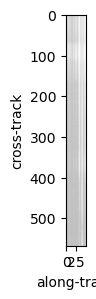

In [17]:
cube_save_dir = '/home/ubuntu/OpenHSIcubes/'
cam.save(save_dir=cube_save_dir)

['long_name', 'units', 'description']
<class 'netCDF4._netCDF4.Variable'>
uint16 datacube(wavelength, x, y)
    long_name: hyperspectral datacube
    units: digital number
    description: hyperspectral datacube
unlimited dimensions: 
current shape = (608, 568, 50)
filling on, default _FillValue of 65535 used


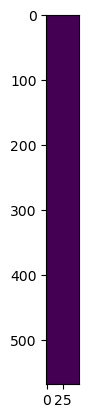

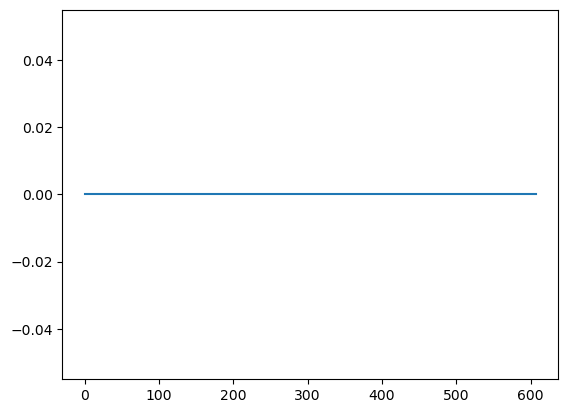

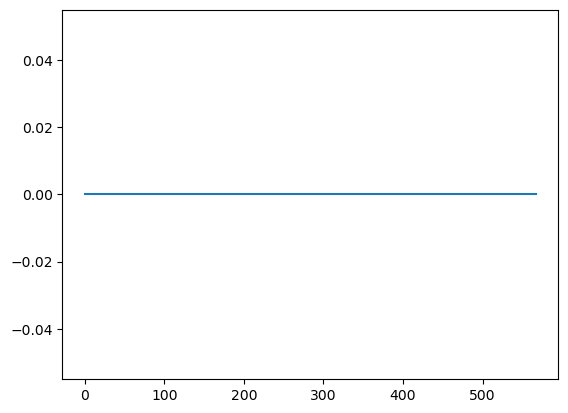

In [18]:
import netCDF4
import matplotlib.pyplot as plt
import numpy as np


data = netCDF4.Dataset('/home/ubuntu/OpenHSIcubes/2024_08_30/2024_08_30-12_29_58.nc', 'r')
variable = data.variables['datacube']  # Replace 'datacube' with your variable

# Get all attribute IDs
attribute_ids = variable.ncattrs()

print(attribute_ids)
print(variable)

band_im = variable[400, :, :]

plt.imshow(band_im[:,:])
plt.show()

plt.plot(variable[:, 275, 10])
plt.show()


plt.plot(variable[400, :, 10])
plt.show()

### Multiprocessing camera export

Export cameras using the SharedOpenHSI class.

In [ ]:
#| export cameras
        
@delegates()
class SharedIDSCamera(IDSCameraBase, SharedOpenHSI):
    pass